# NETSI Special Topic: Causal Analysis
## Jupyter notebook on instrumental variable approach (IV)

In [5]:
## Set seed and parameters
install.packages("AER", dependencies=TRUE)
library(lfe) # for OLS (easier robust SE)
library(AER) # for IV
set.seed(10)
N <- 50000

Installing package into 'C:/Users/quint/OneDrive/Documents/R/win-library/3.6'
(as 'lib' is unspecified)
also installing the dependencies 'spatial', 'gss', 'stabledist', 'bibtex', 'gbRd', 'truncnorm', 'FNN', 'kernlab', 'mclust', 'multicool', 'DistributionUtils', 'GeneralizedHyperbolic', 'TTR', 'timeDate', 'timeSeries', 'fBasics', 'fastICA', 'fracdiff', 'RcppArmadillo', 'statmod', 'Rdpack', 'cubature', 'quadprog', 'maxLik', 'Rsolnp', 'ks', 'spd', 'xts', 'chron', 'SkewHyperbolic', 'expm', 'miscTools', 'VGAM', 'quantmod', 'dynlm', 'fGarch', 'forecast', 'foreign', 'ineq', 'KernSmooth', 'longmemo', 'mlogit', 'np', 'plm', 'pscl', 'rugarch', 'sampleSelection', 'scatterplot3d', 'strucchange', 'systemfit', 'truncreg', 'tseries', 'urca', 'vars'




  There are binary versions available but the source versions are later:
         binary  source needs_compilation
longmemo  1.1-1   1.1-2             FALSE
np       0.60-9 0.60-10              TRUE
AER       1.2-8   1.2-9             FALSE

  Binaries will be installed
package 'spatial' successfully unpacked and MD5 sums checked
package 'gss' successfully unpacked and MD5 sums checked
package 'stabledist' successfully unpacked and MD5 sums checked
package 'bibtex' successfully unpacked and MD5 sums checked
package 'gbRd' successfully unpacked and MD5 sums checked
package 'truncnorm' successfully unpacked and MD5 sums checked
package 'FNN' successfully unpacked and MD5 sums checked
package 'kernlab' successfully unpacked and MD5 sums checked
package 'mclust' successfully unpacked and MD5 sums checked
package 'multicool' successfully unpacked and MD5 sums checked
package 'DistributionUtils' successfully unpacked and MD5 sums checked
package 'GeneralizedHyperbolic' successfully unpacked

installing the source packages 'longmemo', 'AER'

Loading required package: car
Warning message:
"package 'car' was built under R version 3.6.2"Loading required package: lmtest
Warning message:
"package 'lmtest' was built under R version 3.6.2"Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'lmtest'

The following object is masked from 'package:lfe':

    waldtest

Loading required package: sandwich
Loading required package: survival
Warning message:
"package 'survival' was built under R version 3.6.2"

### Naive OLS
Causal link from private to salary is confounded by the household wealth, as in the last notebook.

In [30]:
## Create empty dataframe
df <- data.frame("ID" = 1:N)

## Simulate location (we'll assume private schools are only in urban area)
df$urban <- floor(runif(N, min=0, max=2))

## Simulate household wealth
### Let's assume that what matters is HH wealth is > 1M or not (specific amount does not matter)
df$hhw <- floor(runif(N, min=0, max=2))

## Simulate the kid's decision to attend private college 
### Instead of completely random, more likely to attend private college if from wealthy HH
### Living in urban area can sometimes turn decision toward attending private (but not vice versa)
### Let's follow potential outcomes approach and simulate both private0 (D0) and private1 (D1)
df$private0 <- 0.7*df$hhw + runif(N, min=0, max=1) # private school decision by non-urban (private if >1)
df$private1 <- df$private0 + 0.2 # private school decision by urban (private if >1)
df$private0 <- 1*(df$private0>1) # Replace with binary numbers
df$private1 <- 1*(df$private1>1)

### Check monotonicity
print(table(df$private1>=df$private0))

## Determine private1 vs private0 based on urban status
df$private <- df$urban * df$private1 + (1-df$urban) * df$private0

## Simulate earning
treatment.effect <- 10000
df$salary0 <- 50000 + df$hhw*10000 + rnorm(N, mean=0, sd=40000) ## potential outcome, when attending public (Y0)
df$salary1 <- df$salary0 + treatment.effect ## potential outcome, when attending private (Y1)
df$salary <- df$private * df$salary1 + (1-df$private) * df$salary0

## Some sample data
head(df)

## Regression result
OLS <- felm(salary ~ private, data=df)
print(summary(OLS, robust=TRUE))


 TRUE 
50000 


ID,urban,hhw,private0,private1,private,salary0,salary1,salary
1,0,0,0,0,0,86007.84,96007.839,86007.84
2,1,0,0,0,0,84303.19,94303.189,84303.19
3,0,1,1,1,1,123235.57,133235.573,133235.57
4,0,1,0,1,0,37281.96,47281.958,37281.96
5,1,0,0,1,1,21890.97,31890.966,31890.97
6,1,1,0,0,0,-16241.50,-6241.497,-16241.50



Call:
   felm(formula = salary ~ private, data = df) 

Residuals:
    Min      1Q  Median      3Q     Max 
-176922  -27180    -122   27316  164834 

Coefficients:
            Estimate Robust s.e t value Pr(>|t|)    
(Intercept)  51903.0      243.4  213.23   <2e-16 ***
private      16378.6      362.7   45.16   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 40350 on 49998 degrees of freedom
Multiple R-squared(full model): 0.03913   Adjusted R-squared: 0.03911 
Multiple R-squared(proj model): 0.03913   Adjusted R-squared: 0.03911 
F-statistic(full model, *iid*): 2036 on 1 and 49998 DF, p-value: < 2.2e-16 
F-statistic(proj model):  2040 on 1 and 49998 DF, p-value: < 2.2e-16 




### Instrumental variable approach

As you can see above, we get biased result when we run this Naive regression. Suppose we don't observe household wealth, so including household wealth in our regression is impossible. What can we do?

Fortunately, we have an instrument: urban affects wage only through private (exclusion), being urban can only make you to attend private college (monotonicity), and being in urban is not correlated with private school potential outcomes and wage potential outcomes (exogeneity).

Using this, we can run IV and get unbiased estimate for the causal effect of interest.

In [51]:
IV = ivreg(salary ~ private | urban , data = df)
print(summary(IV, robust=TRUE))


Call:
ivreg(formula = salary ~ private | urban, data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-180704.4  -27403.3    -163.5   27425.0  168830.3 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  55685.2      817.8  68.094  < 2e-16 ***
private       7912.7     1784.8   4.433  9.3e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 40570 on 49998 degrees of freedom
Multiple R-Squared: 0.02868,	Adjusted R-squared: 0.02866 
Wald test: 19.65 on 1 and 49998 DF,  p-value: 9.299e-06 



In [43]:
## Check the result from ivreg is equivalent to FS/RF
FS <- felm(private ~ urban, data = df)
RF <- felm(salary ~ urban, data = df)
FS.coef <- coef(summary(FS))["urban",1]
RF.coef <- coef(summary(RF))["urban",1]
print(RF.coef/FS.coef)

[1] 7912.739


### Causal relationship of the previous simulation represented by DAG

In [44]:
library(igraph) # Some igraph tutorial: https://kateto.net/netscix2016.html

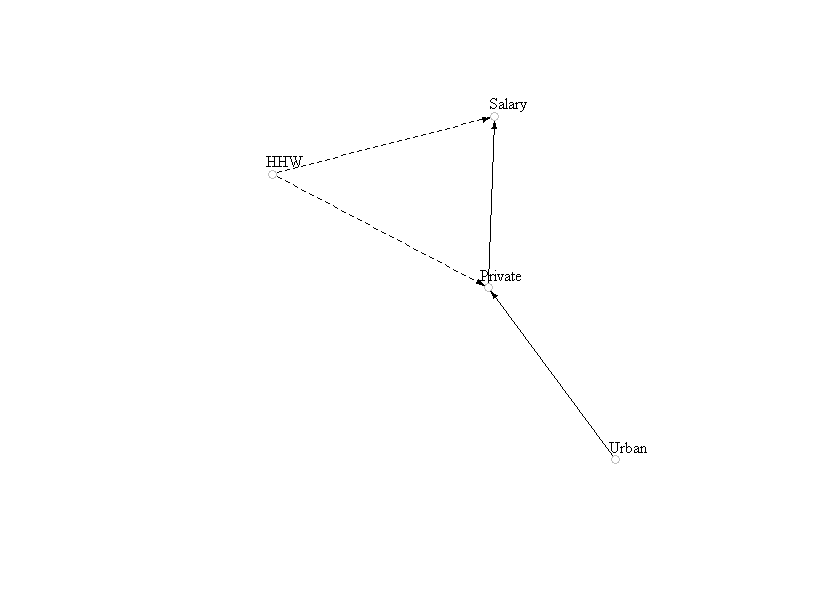

In [45]:
g1 <- graph_from_literal(Urban--+Private,Private--+Salary,HHW--+Private,HHW--+Salary)
E(g1)$lty <- c(1,1,2,2)
options(repr.plot.height=5)
plot(g1, edge.arrow.size=0.5, edge.color="black", vertex.color="white", vertex.size=5, 
     vertex.frame.color="grey", vertex.label.color="black", 
     vertex.label.cex=0.8, vertex.label.dist=1.5, edge.curved=0)

### LATE
To demonstrate that the treatment effect that we're identifying is treatment effect of compliers, let's give much bigger treatment effect to always-takers and never-takers this time.

In [58]:
df.late <- df
te.compliers <- 10000
te.others <- 30000 # 10 times bigger treatment effect

## potential outcome, when attending public (Y0)
df.late$salary0 <- 50000 + df.late$hhw*10000 + rnorm(N, mean=0, sd=40000)

## potential outcome, when attending private (Y1)
df.late$salary1 <- df.late$salary0 + 
                    te.compliers*(df.late$private1>df.late$private0) +
                    te.others*(df.late$private1==df.late$private0)
df.late$salary <- df.late$private * df.late$salary1 + (1-df.late$private) * df.late$salary0

## IV
IV = ivreg(salary ~ private | urban , data = df.late)
print(summary(IV, robust=TRUE))

### Check that the result ~= treatment effect that we gave to the compliers


Call:
ivreg(formula = salary ~ private | urban, data = df.late)

Residuals:
    Min      1Q  Median      3Q     Max 
-183973  -28659    -200   28372  172182 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  61913.8      851.6  72.706  < 2e-16 ***
private      10071.9     1858.6   5.419 6.02e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 42250 on 49998 degrees of freedom
Multiple R-Squared: 0.06916,	Adjusted R-squared: 0.06914 
Wald test: 29.37 on 1 and 49998 DF,  p-value: 6.018e-08 



### Violations of IV assumptions
Now let's take a look at one of the cases where IV assumptions are violated. One example of IV assumption violation is when there is direct effect of being in urban area on our outcome variable (salary). Let's first draw DAG representing this situation, and then simulate it.

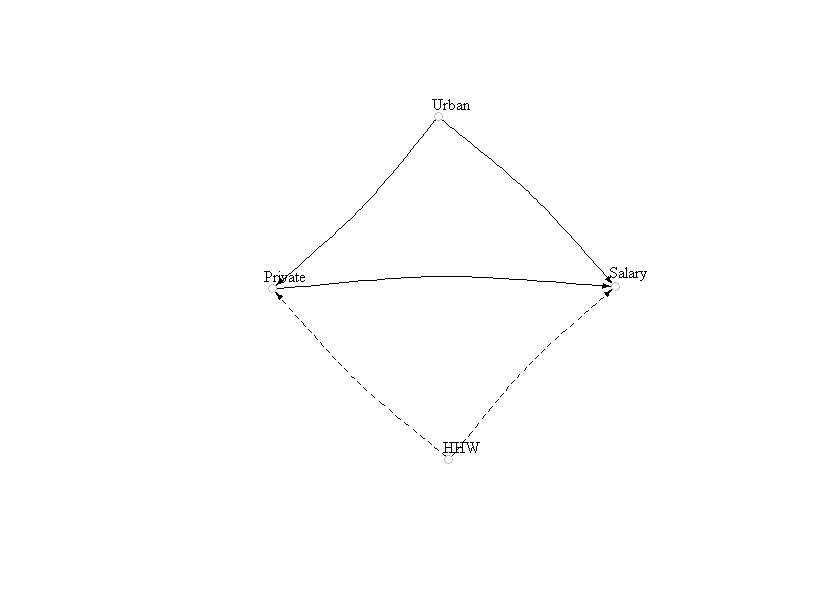

In [38]:
g1 <- graph_from_literal(Urban--+Private,Private--+Salary,HHW--+Private,HHW--+Salary,Urban--+Salary)
E(g1)$lty <- c(1,1,1,2,2)
options(repr.plot.height=5)
plot(g1, edge.arrow.size=0.5, edge.color="black", vertex.color="white", vertex.size=5, 
     vertex.frame.color="grey", vertex.label.color="black", 
     vertex.label.cex=0.8, vertex.label.dist=1.5, edge.curved=0.1)

In [39]:
df.v <- df

## Simulate earning
treatment.effect <- 10000
df.v$salary0 <- 50000 + df.v$hhw*10000 + 10000*df.v$urban + rnorm(N, mean=0, sd=40000) ## potential outcome, when attending public (Y0)
df.v$salary1 <- df.v$salary0 + treatment.effect ## potential outcome, when attending private (Y1)
df.v$salary <- df.v$private * df.v$salary1 + (1-df.v$private) * df.v$salary0

## IV
IV = ivreg(salary ~ private | urban , data = df.v)
print(summary(IV, robust=TRUE))

### As you can see, this can introduce pretty serious problem...


Call:
ivreg(formula = salary ~ private | urban, data = df.v)

Residuals:
    Min      1Q  Median      3Q     Max 
-199353  -30645      39   31264  185223 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  37443.7      913.5   40.99   <2e-16 ***
private      60211.6     1993.7   30.20   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 45320 on 49998 degrees of freedom
Multiple R-Squared: -0.1926,	Adjusted R-squared: -0.1926 
Wald test: 912.1 on 1 and 49998 DF,  p-value: < 2.2e-16 



### Exercise
Show a simulation exercise where another IV assumption is violoated.

I will show a situation where the monotonicity condition is violated. In this case, this means that living in a urban area can not only turn the schooling decision towards private education but also sometimes toward public education.
I generate the private potential outcomes in the same way as before, but now when the urban variable is 1 the subject will be more likely to go in a private school in 90% of the cases, and it will be less likely to do so in 10% of the cases.

In [218]:
df.vM <- df

UrbanEffectTresh = 0.9 #probability of decreased likelihood of private school when living in a urban zone
df.vM$private0 <- 0.7*df.vM$hhw + runif(N, min=0, max=1) 
df.vM$private1 <- df.vM$private0 + ifelse(runif(N,min=0,max=1)>UrbanEffectTresh, -0.2, 0.2)
df.vM$private0 <- 1*(df.vM$private0>1)
df.vM$private1 <- 1*(df.vM$private1>1)
df.vM$private <- df.vM$urban * df.vM$private1 + (1-df.vM$urban) * df.vM$private0

## Simulate earning
treatment.effect <- 10000
df.vM$salary0 <- 50000 + df.vM$hhw*10000 + rnorm(N, mean=0, sd=40000) ## potential outcome, when attending public (Y0)
df.vM$salary1 <- df.vM$salary0 + treatment.effect ## potential outcome, when attending private (Y1)
df.vM$salary <- df.vM$private * df.vM$salary1 + (1-df.vM$private) * df.vM$salary0
IV = ivreg(salary ~ private | urban , data = df.vM)
print(summary(IV, robust=TRUE))



Call:
ivreg(formula = salary ~ private | urban, data = df.vM)

Residuals:
      Min        1Q    Median        3Q       Max 
-179543.4  -26925.1     341.5   26847.2  165772.5 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  53926.4      929.2  58.038  < 2e-16 ***
private      12344.7     2115.8   5.834 5.43e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 39980 on 49998 degrees of freedom
Multiple R-Squared: 0.04011,	Adjusted R-squared: 0.04009 
Wald test: 34.04 on 1 and 49998 DF,  p-value: 5.429e-09 



It seems the estimate for private is substantially larger than the treatment effect, but the difference could still be due to chance. Let's try with a larger number of defiers, that is, with a larger probability that living in an urban area decreases the likelihood of going to private school.

In [168]:
df.vM <- df


UrbanEffectTresh = 0.5   #probability of decreased likelihood of private school when living in a urban zone
df.vM$private0 <- 0.7*df.vM$hhw + runif(N, min=0, max=1) 
df.vM$private1 <- df.vM$private0 + ifelse(runif(N,min=0,max=1)>UrbanEffectTresh, -0.2, 0.2) 
df.vM$private0 <- 1*(df.vM$private0>1) 
df.vM$private1 <- 1*(df.vM$private1>1)
df.vM$private <- df.vM$urban * df.vM$private1 + (1-df.vM$urban) * df.vM$private0

## Simulate earning
treatment.effect <- 10000
df.vM$salary0 <- 50000 + df.vM$hhw*10000 + rnorm(N, mean=0, sd=40000) ## potential outcome, when attending public (Y0)
df.vM$salary1 <- df.vM$salary0 + treatment.effect ## potential outcome, when attending private (Y1)
df.vM$salary <- df.vM$private * df.vM$salary1 + (1-df.vM$private) * df.vM$salary0
IV = ivreg(salary ~ private | urban , data = df.vM)
print(summary(IV, robust=TRUE))


Call:
ivreg(formula = salary ~ private | urban, data = df.vM)

Residuals:
      Min        1Q    Median        3Q       Max 
-151956.9  -27213.8    -136.5   27600.4  170255.3 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    55504       2830  19.616   <2e-16 ***
private         8525       7639   1.116    0.264    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 40460 on 49998 degrees of freedom
Multiple R-Squared: 0.0303,	Adjusted R-squared: 0.03028 
Wald test: 1.245 on 1 and 49998 DF,  p-value: 0.2645 



Now the estimate is actually smaller than the treatment effect, and much closer to it, what is surprising. The only option left is to increase the effect of the urban variable itself. 

In [169]:
df.vM <- df


UrbanEffectTresh = 0.5   #probability of decreased likelihood of private school when living in a urban zone
df.vM$private0 <- 0.7*df.vM$hhw + runif(N, min=0, max=1) 
df.vM$private1 <- df.vM$private0 + ifelse(runif(N,min=0,max=1)>UrbanEffectTresh, -0.5, 0.5) 
df.vM$private0 <- 1*(df.vM$private0>1)
df.vM$private1 <- 1*(df.vM$private1>1)
df.vM$private <- df.vM$urban * df.vM$private1 + (1-df.vM$urban) * df.vM$private0

## Simulate earning
treatment.effect <- 10000
df.vM$salary0 <- 50000 + df.vM$hhw*10000 + rnorm(N, mean=0, sd=40000) ## potential outcome, when attending public (Y0)
df.vM$salary1 <- df.vM$salary0 + treatment.effect ## potential outcome, when attending private (Y1)
df.vM$salary <- df.vM$private * df.vM$salary1 + (1-df.vM$private) * df.vM$salary0
IV = ivreg(salary ~ private | urban , data = df.vM)
print(summary(IV, robust=TRUE))


Call:
ivreg(formula = salary ~ private | urban, data = df.vM)

Residuals:
      Min        1Q    Median        3Q       Max 
-170644.1  -27609.9    -296.9   27562.2  166831.3 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    58312       2035  28.658   <2e-16 ***
private         1492       5244   0.285    0.776    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 40780 on 49998 degrees of freedom
Multiple R-Squared: 0.00612,	Adjusted R-squared: 0.0061 
Wald test: 0.08098 on 1 and 49998 DF,  p-value: 0.776 



With this modification the estimate for private is now clearly below the treatment effect, and is not significative. However, it is not clear how the violation of the monotonicity assumption affects the estimate, if it is by increasing or decreasing it. It seems, in addition, that the errors for the estimate are now larger than they were before. To get a better grasp at what is happening here, I will now run 100 simulations for values of the UrbanEffectTreshold from 1 to 0.5, keeping a strong effect of the Urban variable as it is in the previous simulation. 

In [208]:
estimates <- matrix(nrow = 6, ncol = 100)
UrbanEffectTreshs = seq(1,0.5,-0.1)

for(i in 1:6) {
    for(sim in 1:100) {        
        df.vM <- df        
        df.vM$private0 <- 0.7*df.vM$hhw + runif(N, min=0, max=1) 
        df.vM$private1 <- df.vM$private0 + ifelse(runif(N,min=0,max=1)>UrbanEffectTreshs[i], -0.5, 0.5) 
        df.vM$private0 <- 1*(df.vM$private0>1)
        df.vM$private1 <- 1*(df.vM$private1>1)
        df.vM$private <- df.vM$urban * df.vM$private1 + (1-df.vM$urban) * df.vM$private0

        ## Simulate earning
        treatment.effect <- 10000
        df.vM$salary0 <- 50000 + df.vM$hhw*10000 + rnorm(N, mean=0, sd=40000) ## potential outcome, when attending public (Y0)
        df.vM$salary1 <- df.vM$salary0 + treatment.effect ## potential outcome, when attending private (Y1)
        df.vM$salary <- df.vM$private * df.vM$salary1 + (1-df.vM$private) * df.vM$salary0
        IV = ivreg(salary ~ private | urban , data = df.vM)
        estimates[i,sim] = IV$coefficients[2]
    }
}


Plotting simple histograms of the estimates for each treshold will give an overview of the effect, as well as calculating the mean and standard deviation of the estimates:

[1]  9944.076 10082.915  9680.551  9762.296 10003.703  8925.196
[1]  814.7989 1082.3532 1418.6176 1710.3211 2468.8285 4855.0024


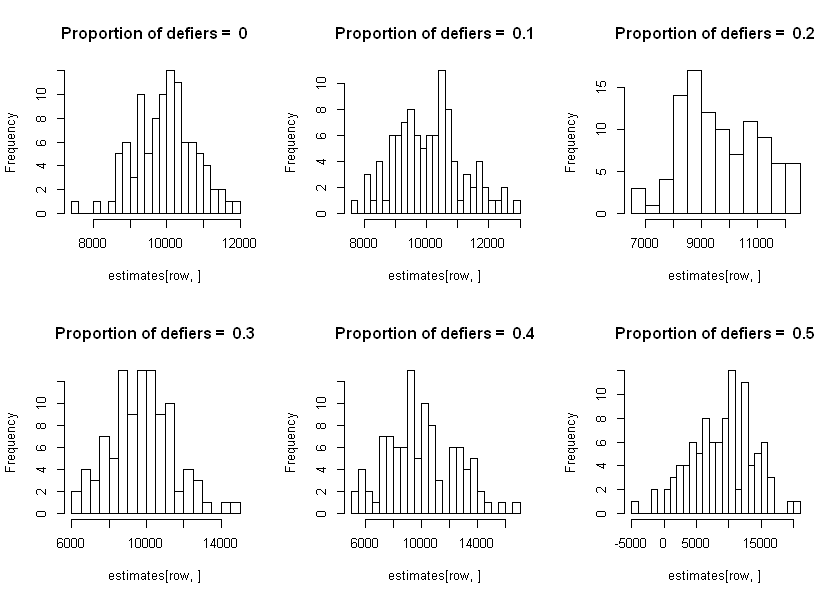

In [217]:
par(mfrow=c(2,3))
for(row in 1:6) {
    
    hist(estimates[row,], breaks = 20, pin = c(0.1,0.1), main = paste("Proportion of defiers = ", as.character(1-UrbanEffectTreshs[row])))
}
print(apply(estimates,1,mean))
print(apply(estimates,1,sd))

It seems introducing more defiers does not introduce bias to the value of the estimate, as the different values for each treshold are broadly centered around the real value of the treatment effect, but instead increases the variance for this estimate, what in the more extreme cases can even lead to a negative estimate. However, a large proportion of defiers seems to be needed for this violation of the monotonicity assumption to have an important impact.